# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
качество предсказания;
скорость предсказания;
время обучения.

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [239]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [240]:
df = df.drop(np.where(df['RegistrationYear'] >2020)[0])

In [241]:
df = df.drop(np.where(df['RegistrationYear'] < 1910)[0])

In [242]:
df.Price.isna().sum()

0

Text(0.5, 1.0, 'Price Per Auto')

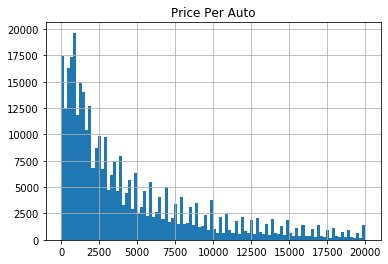

In [243]:
df.Price.hist(bins=100)
plt.title('Price Per Auto')

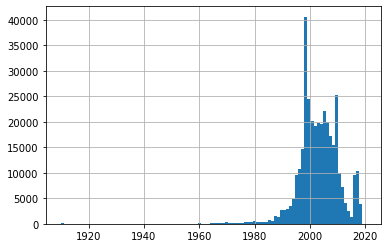

In [244]:
df.RegistrationYear.hist(bins=100, range=(1910, 2020))

In [245]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [246]:
df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1, inplace=True)

In [247]:
df.loc[(df.loc[:,'Power']<=30) | (df.loc[:,'Power']>=700)] = -1

In [248]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [249]:
df = df.fillna('unknown')

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354198 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354198 non-null  int64 
 1   VehicleType       354198 non-null  object
 2   RegistrationYear  354198 non-null  int64 
 3   Gearbox           354198 non-null  object
 4   Power             354198 non-null  int64 
 5   Model             354198 non-null  object
 6   Kilometer         354198 non-null  int64 
 7   FuelType          354198 non-null  object
 8   Brand             354198 non-null  object
 9   NotRepaired       354198 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Таким образом, мы импортировали исходные данные.
Удалили данные, в которых год регистрации >2020 и <1910 (невозможные значения годов выпуска машин)
Удалили строки с нулевой ценой, т.к. учитывать такие данные в нашей модели - бесполезно;
Заменили значением -1 невозможные мощности двигателя - Power (менее 30 и более 700); 
Исключили столбцы, не имеющие прямого влияния на цену автомобиля
('DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen').

# 2.Обучение 

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor 

In [252]:
X = df.drop('Price',axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [253]:
cat_features = ['VehicleType','RegistrationYear', 'Gearbox','Power', 'Model','Kilometer','FuelType', 'Brand', 'NotRepaired']

In [254]:
catboost = CatBoostRegressor(loss_function='RMSE', iterations=50)

In [255]:
catboost.fit(X_train,y_train,cat_features=cat_features, verbose=10)

Learning rate set to 0.5
0:	learn: 3359.1342361	total: 276ms	remaining: 13.5s
10:	learn: 2011.8525894	total: 1.24s	remaining: 4.41s
20:	learn: 1919.8554639	total: 2.03s	remaining: 2.81s
30:	learn: 1879.3481727	total: 2.81s	remaining: 1.72s
40:	learn: 1844.5115949	total: 3.58s	remaining: 785ms
49:	learn: 1824.2700518	total: 4.78s	remaining: 0us


In [256]:
prediction = catboost.predict(X_test)

In [257]:
rmse = np.sqrt(mean_squared_error(y_test,prediction))
rmse

1814.9897429274292

Попробуем пофитить модель с другими гиперпараметрами ( изменим функцию потерь и количество итераций)

In [258]:
catboost2 = CatBoostRegressor(loss_function='MAE',iterations=100)

In [259]:
catboost2.fit(X_train,y_train,cat_features=cat_features, verbose=10)

0:	learn: 3220.4921322	total: 151ms	remaining: 15s
10:	learn: 2652.8354166	total: 1.25s	remaining: 10.1s
20:	learn: 2257.1078575	total: 2.82s	remaining: 10.6s
30:	learn: 1992.3263342	total: 4.02s	remaining: 8.96s
40:	learn: 1825.9478732	total: 5.04s	remaining: 7.26s
50:	learn: 1711.5025618	total: 6.07s	remaining: 5.83s
60:	learn: 1619.9012670	total: 7.12s	remaining: 4.55s
70:	learn: 1521.2058221	total: 8.79s	remaining: 3.59s
80:	learn: 1461.6838896	total: 9.88s	remaining: 2.32s
90:	learn: 1426.4698378	total: 11.2s	remaining: 1.11s
99:	learn: 1402.5558439	total: 12.2s	remaining: 0us


In [260]:
prediction2 = catboost2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,prediction2))
rmse

2396.9095813728354

In [261]:
catboost3 = CatBoostRegressor(loss_function='MAPE',iterations=100)

In [262]:
catboost3.fit(X_train,y_train,cat_features=cat_features, verbose=10)

0:	learn: 0.8852837	total: 102ms	remaining: 10.1s
10:	learn: 0.8796705	total: 983ms	remaining: 7.95s
20:	learn: 0.8755277	total: 1.86s	remaining: 7.02s
30:	learn: 0.8724710	total: 2.73s	remaining: 6.08s
40:	learn: 0.8702111	total: 3.66s	remaining: 5.27s
50:	learn: 0.8685458	total: 4.79s	remaining: 4.61s
60:	learn: 0.8673173	total: 6.62s	remaining: 4.23s
70:	learn: 0.8664117	total: 7.57s	remaining: 3.09s
80:	learn: 0.8657417	total: 8.5s	remaining: 1.99s
90:	learn: 0.8652472	total: 9.64s	remaining: 953ms
99:	learn: 0.8649154	total: 10.6s	remaining: 0us


In [263]:
prediction3 = catboost3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,prediction3))
rmse

6191.10053574591

Как мы видим, наилучшей метрикой функции потерь является RMSE (rmse=1814.98) \
loss_function='MAE', iterations=100: rmse = 2396.91\
loss_function='MAPE', iterations=100: rmse= 6191.1

Построим модель на базе библиотеки LightGBM и сравним с CatBoost

In [264]:
import lightgbm as lgb

In [265]:
categ_features = ['VehicleType','RegistrationYear', 'Gearbox','Power', 'Model','Kilometer','FuelType', 'Brand', 'NotRepaired']

In [266]:
for c in categ_features:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

/Users/lubava/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lubava/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [267]:
lgb_train = lgb.Dataset(X_train, y_train)

In [268]:
params = {'metric': ['rmse']}

In [269]:
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=30,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's rmse: 2496.28
[20]	training's rmse: 1917.98
[30]	training's rmse: 1743.91


In [270]:
lgb_prediction = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction))
rmse

1769.753379741759

In [271]:
params = {'metric': ['mape']}
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=100,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's mape: 248.307
[20]	training's mape: 127.265
[30]	training's mape: 81.4057
[40]	training's mape: 65.2928
[50]	training's mape: 59.7719
[60]	training's mape: 57.3219
[70]	training's mape: 56.1289
[80]	training's mape: 56.0132
[90]	training's mape: 55.3172
[100]	training's mape: 54.7146


In [275]:
lgb_prediction2 = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction2))
rmse

1622.0517147298674

In [276]:
params = {'metric': ['mae']}
lightgbm = lgb.train(params,
                lgb_train, 
                num_boost_round=100,
                valid_sets=[lgb_train],  
                verbose_eval=10)

[10]	training's l1: 1792.81
[20]	training's l1: 1243.53
[30]	training's l1: 1058.3
[40]	training's l1: 987.652
[50]	training's l1: 955.842
[60]	training's l1: 938.402
[70]	training's l1: 926.505
[80]	training's l1: 917.721
[90]	training's l1: 911.018
[100]	training's l1: 904.724


In [277]:
lgb_prediction3 = lightgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,lgb_prediction3))
rmse

1622.0517147298674

# Вывод

Таким образом, мы построили модели на базе библиотек catboost и lightgbm. \
Для трёх наборов гиперпараметров (loss_function='RMSE', iterations=50), \
(loss_function = 'MAE', iterations=100),\
(loss_function=MAPE, iterations=100) -  модели протестированы по точности (метрика RMSE), скорости обучения и предсказания.\
В обоих случаях catboost-модели оказались быстрее по времени предсказания, но менее точными, и более медленными при обучении.